In [1]:
3+7

10

FULL DATASET CLUSTERING - OPTIMIZED FOR 495K ROWS

[1/6] Loading data...
✓ Loaded: (495730, 47)
✓ Using full dataset: 495,730 rows

[2/6] Preparing data...
✓ Found 35 numerical features
✓ Selected top 25 features by variance
✓ Clean dataset: (492699, 25)
✓ Features used: Location_Desc_Crime_Count, Crime_Type_Frequency, Community_Crime_Count, Hourly_Crime_Count, District_Crime_Count...

[3/6] Scaling features...
✓ Scaled: (492699, 25)

[4/6] Finding optimal k (testing 2-7)...
  k=2... ✓ (silhouette: 0.113)
  k=3... ✓ (silhouette: 0.079)
  k=4... ✓ (silhouette: 0.079)
  k=5... ✓ (silhouette: 0.073)
  k=6... ✓ (silhouette: 0.064)
  k=7... ✓ (silhouette: 0.075)


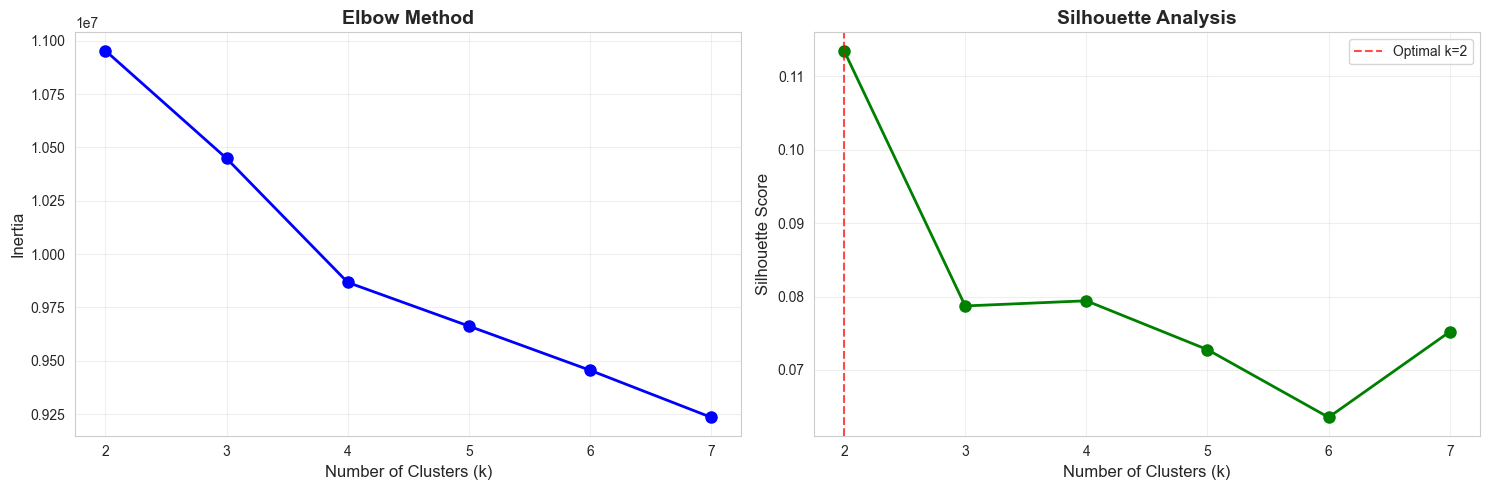


✓ OPTIMAL K = 2 (Silhouette: 0.113)

[5/6] Final clustering with k=2...
  Running MiniBatch K-Means... ✓ 2 clusters
  DBSCAN: Skipped (too slow for large dataset)

[6/6] Visualization...
  Sampling 15,000 points for visualization...
✓ PCA explained variance: 22.9%


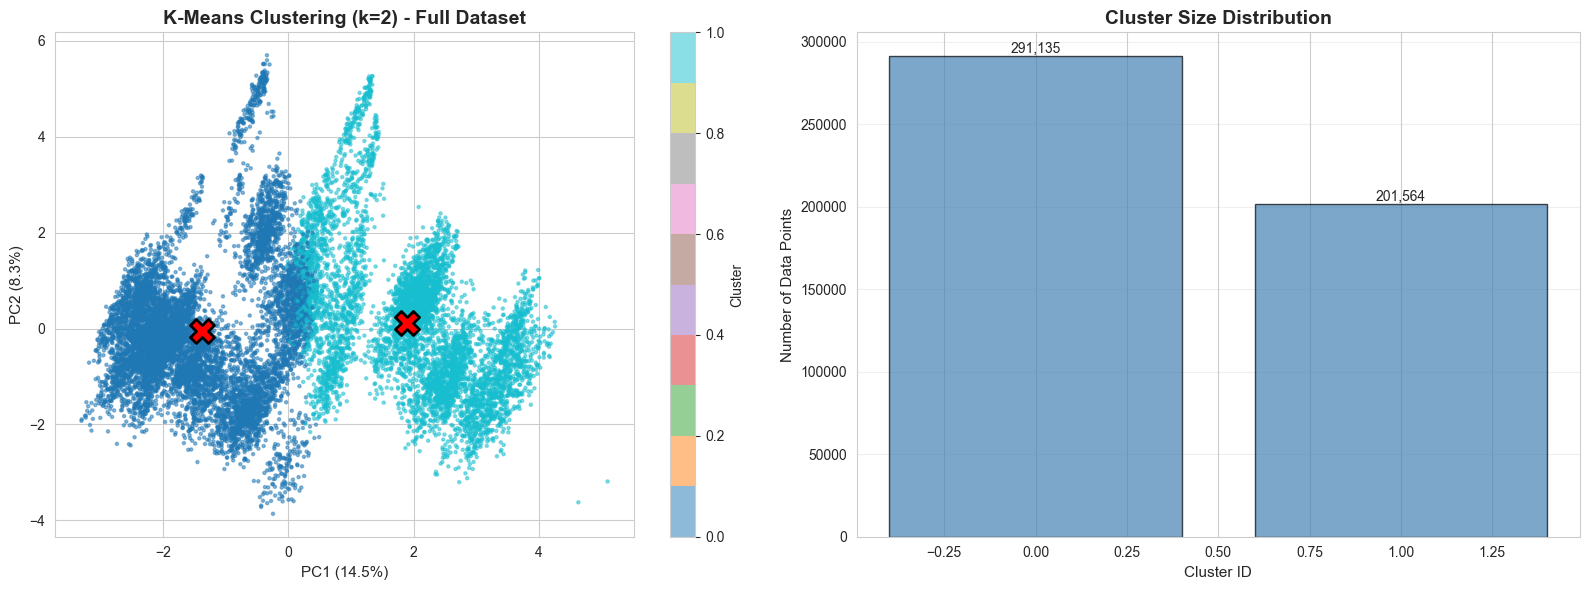


CLUSTER ANALYSIS

📊 CLUSTER 0
   Size: 291,135 points (59.1%)
   Top 5 characteristics:
   1. DOW_Crime_Count: 70811.08
   2. Location_Desc_Crime_Count: 69077.01
   3. Crime_Type_Frequency: 60432.14
   4. Monthly_Crime_Count: 41533.16
   5. District_Crime_Count: 25989.29

📊 CLUSTER 1
   Size: 201,564 points (40.9%)
   Top 5 characteristics:
   1. DOW_Crime_Count: 70897.32
   2. Crime_Type_Frequency: 66094.83
   3. Location_Desc_Crime_Count: 61052.48
   4. Monthly_Crime_Count: 41497.83
   5. Hourly_Crime_Count: 22663.52

CLUSTER METRICS (sampled)
Silhouette Score:    0.1101 (higher is better, -1 to 1)
Calinski-Harabasz:   1217.31 (higher is better)
Davies-Bouldin:      2.7858 (lower is better)

SAVING RESULTS
✓ Saved: crime_data_clustered_full.csv (492,699 rows)
✓ Saved: cluster_summary_full.csv

✓ COMPLETE! Total time: 7.7 minutes

📈 INTERPRETATION GUIDE:
✓ Silhouette > 0.5: Strong clusters
✓ Silhouette 0.3-0.5: Reasonable clusters
⚠ Silhouette < 0.3: Weak clusters (consider different

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
import time
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("="*70)
print("FULL DATASET CLUSTERING - OPTIMIZED FOR 495K ROWS")
print("="*70)

start_time = time.time()

# ============================================================================
# CONFIGURATION
# ============================================================================
USE_FULL_DATA = True  # Set to False to use 50k sample
SAMPLE_SIZE = 50000
K_RANGE = range(2, 8)  # Test k from 2 to 7

# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================
print("\n[1/6] Loading data...")

data_path = r'C:\project\PatrolIQ  project\feature_engineering'

try:
    df_original = pd.read_csv(os.path.join(data_path, 'engineered_crime_data.csv'))
    print(f"✓ Loaded: {df_original.shape}")
    
    if not USE_FULL_DATA and df_original.shape[0] > SAMPLE_SIZE:
        print(f"  Sampling {SAMPLE_SIZE} rows...")
        df_original = df_original.sample(n=SAMPLE_SIZE, random_state=42)
        print(f"✓ Using: {df_original.shape}")
    else:
        print(f"✓ Using full dataset: {df_original.shape[0]:,} rows")
        
except Exception as e:
    print(f"✗ Error: {e}")
    exit()

# ============================================================================
# STEP 2: PREPARE DATA
# ============================================================================
print("\n[2/6] Preparing data...")

df = df_original.copy()

# Select numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
id_cols = ['id', 'index', 'Unnamed: 0', 'ID', 'Index', 'Id']  # Added 'Id'
numerical_cols = [col for col in numerical_cols if col not in id_cols]

print(f"✓ Found {len(numerical_cols)} numerical features")

# Feature selection: Keep top features by variance
if len(numerical_cols) > 25:
    variances = df[numerical_cols].var().sort_values(ascending=False)
    numerical_cols = variances.head(25).index.tolist()
    print(f"✓ Selected top 25 features by variance")

df_clean = df[numerical_cols].copy()

# Handle missing and clean
df_clean = df_clean.fillna(df_clean.median())
df_clean = df_clean.drop_duplicates()

# Remove zero-variance columns
variance = df_clean.var()
zero_var = variance[variance == 0].index.tolist()
if zero_var:
    numerical_cols = [col for col in numerical_cols if col not in zero_var]
    df_clean = df_clean[numerical_cols]

print(f"✓ Clean dataset: {df_clean.shape}")
print(f"✓ Features used: {', '.join(numerical_cols[:5])}...")

# ============================================================================
# STEP 3: SCALING
# ============================================================================
print("\n[3/6] Scaling features...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)
print(f"✓ Scaled: {X_scaled.shape}")

# ============================================================================
# STEP 4: FIND OPTIMAL K (USING MINI-BATCH FOR SPEED)
# ============================================================================
print(f"\n[4/6] Finding optimal k (testing {min(K_RANGE)}-{max(K_RANGE)})...")

inertias = []
silhouette_scores = []

for k in K_RANGE:
    print(f"  k={k}...", end=' ')
    
    # Use MiniBatchKMeans for large datasets (much faster)
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000, n_init=3)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    
    # Sample for silhouette (too slow on full data)
    sample_size = min(20000, len(X_scaled))
    sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
    sil_score = silhouette_score(X_scaled[sample_idx], labels[sample_idx])
    silhouette_scores.append(sil_score)
    
    print(f"✓ (silhouette: {sil_score:.3f})")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_RANGE, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_RANGE, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mark optimal k
optimal_idx = np.argmax(silhouette_scores)
optimal_k = K_RANGE[optimal_idx]
axes[1].axvline(optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
axes[1].legend()

plt.tight_layout()
plt.savefig('optimal_clusters_full.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ OPTIMAL K = {optimal_k} (Silhouette: {silhouette_scores[optimal_idx]:.3f})")

# ============================================================================
# STEP 5: FINAL CLUSTERING
# ============================================================================
print(f"\n[5/6] Final clustering with k={optimal_k}...")

# K-Means (Mini-Batch for speed)
print("  Running MiniBatch K-Means...", end=' ')
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=10000, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)
print(f"✓ {len(np.unique(labels_kmeans))} clusters")

# DBSCAN - Skip for large datasets (too slow)
print("  DBSCAN: Skipped (too slow for large dataset)")
labels_dbscan = None

# ============================================================================
# STEP 6: VISUALIZE
# ============================================================================
print("\n[6/6] Visualization...")

# Sample for visualization
vis_size = min(15000, len(X_scaled))
print(f"  Sampling {vis_size:,} points for visualization...")
vis_idx = np.random.choice(len(X_scaled), vis_size, replace=False)

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled[vis_idx])
centers_pca = pca.transform(kmeans.cluster_centers_)

print(f"✓ PCA explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=labels_kmeans[vis_idx], 
                          cmap='tab10', alpha=0.5, s=5)
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], 
                c='red', marker='X', s=300, edgecolors='black', linewidths=2)
axes[0].set_title(f'K-Means Clustering (k={optimal_k}) - Full Dataset', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Cluster sizes
cluster_counts = pd.Series(labels_kmeans).value_counts().sort_index()
bars = axes[1].bar(cluster_counts.index, cluster_counts.values, 
                   color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster ID', fontsize=11)
axes[1].set_ylabel('Number of Data Points', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('clustering_results_full.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# CLUSTER ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("CLUSTER ANALYSIS")
print("="*70)

df_clean['Cluster'] = labels_kmeans

for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean['Cluster'] == cluster_id]
    pct = len(cluster_data) / len(df_clean) * 100
    
    print(f"\n📊 CLUSTER {cluster_id}")
    print(f"   Size: {len(cluster_data):,} points ({pct:.1f}%)")
    print(f"   Top 5 characteristics:")
    
    # Get top features by mean value
    top_features = cluster_data[numerical_cols[:10]].mean().sort_values(ascending=False).head(5)
    for i, (feat, val) in enumerate(top_features.items(), 1):
        print(f"   {i}. {feat}: {val:.2f}")

# Calculate cluster metrics
print("\n" + "="*70)
print("CLUSTER METRICS (sampled)")
print("="*70)

# Sample for metrics calculation
sample_size = min(10000, len(X_scaled))
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)

silhouette = silhouette_score(X_scaled[sample_idx], labels_kmeans[sample_idx])
calinski = calinski_harabasz_score(X_scaled[sample_idx], labels_kmeans[sample_idx])
davies = davies_bouldin_score(X_scaled[sample_idx], labels_kmeans[sample_idx])

print(f"Silhouette Score:    {silhouette:.4f} (higher is better, -1 to 1)")
print(f"Calinski-Harabasz:   {calinski:.2f} (higher is better)")
print(f"Davies-Bouldin:      {davies:.4f} (lower is better)")

# ============================================================================
# SAVE RESULTS
# ============================================================================
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

df_clean.to_csv('crime_data_clustered_full.csv', index=False)
print(f"✓ Saved: crime_data_clustered_full.csv ({df_clean.shape[0]:,} rows)")

# Save cluster summary
cluster_summary = pd.DataFrame({
    'Cluster': range(optimal_k),
    'Size': [len(df_clean[df_clean['Cluster'] == i]) for i in range(optimal_k)],
    'Percentage': [len(df_clean[df_clean['Cluster'] == i])/len(df_clean)*100 for i in range(optimal_k)]
})
cluster_summary.to_csv('cluster_summary_full.csv', index=False)
print(f"✓ Saved: cluster_summary_full.csv")

elapsed = time.time() - start_time
print(f"\n✓ COMPLETE! Total time: {elapsed/60:.1f} minutes")
print("="*70)

print("\n📈 INTERPRETATION GUIDE:")
print("="*70)
print("✓ Silhouette > 0.5: Strong clusters")
print("✓ Silhouette 0.3-0.5: Reasonable clusters")
print("⚠ Silhouette < 0.3: Weak clusters (consider different k or features)")
print("\nYour score:", silhouette, "- Check if more/fewer clusters improve this!")